In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

def read(file):
    file = pd.read_excel(file)
    return file.set_index("date")

In [4]:
sse = read("SSE Composite Index.xlsx")
hsi = read("Hang_Seng_Index.xlsx")
n225 = read("Nikkei 225.xlsx")
inx = read("S&P 500.xlsx")
xjo = read("S&P_ASX 200.xlsx")
audusd = read("AUDUSD.xlsx")
xauaud = read("XAU AUD.xlsx")

data = pd.concat([sse, hsi, n225, inx, xjo, audusd, xauaud], axis=1, join='inner')
before = data.loc['2001-1-1':'2006-12-31']
gfc = data.loc['2007-1-1':'2009-12-31']
after = data.loc['2010-1-1':]

In [5]:
def efficient_frontier(data, num_ports, ymin, ymax):
    log_ret = data.pct_change()
    all_weights = np.zeros((num_ports, len(data.columns)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)

    for x in range(num_ports):
        # Weights
        weights = np.array(np.random.random(7))
        weights = weights/np.sum(weights)

        # Save weights
        all_weights[x,:] = weights

        # Expected return
        ret_arr[x] = np.sum( (log_ret.mean() * weights * 252))

        # Expected volatility
        vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))

        # Sharpe Ratio
        sharpe_arr[x] = ret_arr[x]/vol_arr[x]

    max_sr_ret = ret_arr[sharpe_arr.argmax()]
    max_sr_vol = vol_arr[sharpe_arr.argmax()]
    
    def get_ret_vol_sr(weights):
        weights = np.array(weights)
        ret = np.sum(log_ret.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
        sr = ret/vol
        return np.array([ret, vol, sr])

    def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
        return get_ret_vol_sr(weights)[2] * -1

    def check_sum(weights):
        #return 0 if sum of the weights is 1
        return np.sum(weights)-1

    def minimize_volatility(weights):
        return get_ret_vol_sr(weights)[1]

    cons = {"type":"eq","fun":check_sum}
    bounds = ((0,1),(0,1),(0,1),(0,1),(0,1),(0,1),(0,1))
    init_guess = [0.25,0.25,0.25,0.25,0.25,0.25,0.25]

    opt_results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=cons)
    print(opt_results,"\n\n")
    #print(get_ret_vol_sr(opt_results.x))
    
    frontier_y = np.linspace(ymin,ymax,60)
    frontier_x = []

    for possible_return in frontier_y:
        cons = ({'type':'eq', 'fun':check_sum},
                {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})

        result = minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
        frontier_x.append(result['fun'])
    df = pd.DataFrame([sharpe_arr,vol_arr,ret_arr,frontier_x,frontier_y])
    return df, get_ret_vol_sr(opt_results.x)

In [6]:
a,a_ans = efficient_frontier(before,1000,0.03,0.118)
b,b_ans = efficient_frontier(gfc,1000,-0.05,0.175)
c,c_ans = efficient_frontier(after,1000,-0.05,0.175)

     fun: -1.557375244884282
     jac: array([-4.74154949e-05,  7.16625065e-01,  8.53221282e-01, -9.07182693e-05,
        2.33054161e-05, -4.47034836e-07, -1.12503767e-05])
 message: 'Optimization terminated successfully.'
    nfev: 95
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([2.34721492e-02, 3.05520091e-16, 0.00000000e+00, 2.25427488e-02,
       2.72766896e-01, 4.15450996e-01, 2.65767210e-01]) 


     fun: -1.159566475145472
     jac: array([-1.96029246e-03, -1.41163170e-03,  1.86664246e+00,  4.13966388e-01,
        7.53365695e-01, -5.70848584e-04,  7.53551722e-04])
 message: 'Optimization terminated successfully.'
    nfev: 85
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([6.09709795e-02, 1.65871571e-02, 4.31696101e-15, 6.91228013e-16,
       2.13412492e-15, 4.16921751e-01, 5.05520113e-01]) 


     fun: -1.102188052314905
     jac: array([ 3.62003788e-01,  2.71367639e-01,  1.05798244e-06,  1.93715096e-06,
        7.11348653e-02,  1.861

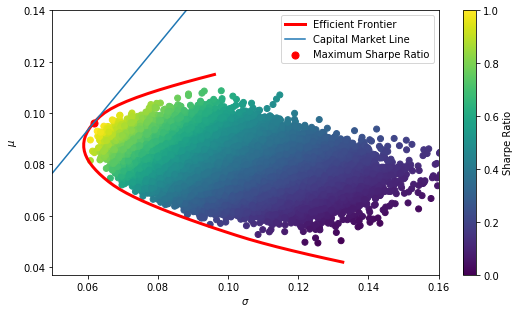

In [5]:
plt.figure(figsize=(16/1.85,9/1.85))
plt.scatter(a.loc[1], a.loc[2], c=a.loc[0], cmap='viridis')
plt.xlim([0.05,0.16])
plt.ylim([0.037,0.14])
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.plot(a.loc[3,8:57],a.loc[4,8:57], 'r-', linewidth=3, label="Efficient Frontier")
plt.plot([0.05,0.09],[0.0766412,0.143104], label="Capital Market Line")
plt.scatter(a_ans[1], a_ans[0],c='red', s=50, label = "Maximum Sharpe Ratio")
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.savefig('before.pdf')
plt.savefig('before.png')
plt.show()

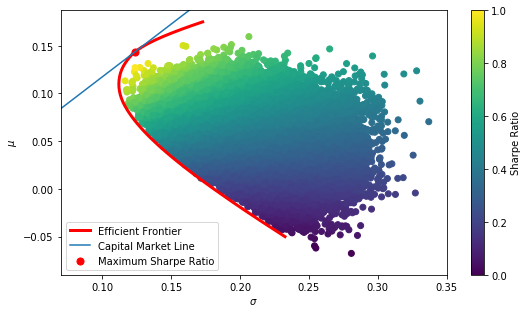

In [6]:
plt.figure(figsize=(16/1.85,9/1.85))
plt.xlim([0.07,0.35])
plt.ylim([-0.09,0.187102])
plt.scatter(b.loc[1], b.loc[2], c=b.loc[0], cmap='viridis')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.plot(b.loc[3],b.loc[4],'r-', linewidth=3, label="Efficient Frontier")
plt.plot([0.07,0.175],[0.0840255, 0.200223], label="Capital Market Line")
plt.scatter(b_ans[1],b_ans[0],c='red', s=50,label = "Maximum Sharpe Ratio")
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.savefig('gfc.pdf')
plt.savefig('gfc.png')
plt.show()

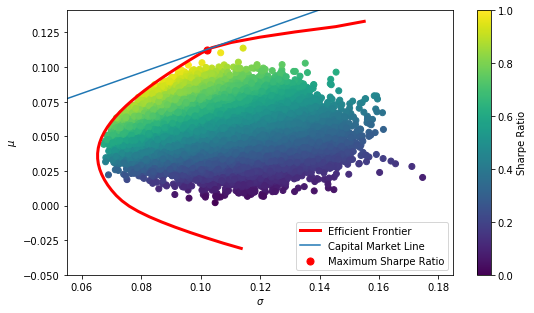

In [7]:
plt.figure(figsize=(16/1.85,9/1.85))
plt.xlim([0.055,0.185])
plt.ylim([-0.05,0.141])
plt.scatter(c.loc[1], c.loc[2], c=c.loc[0], cmap='viridis')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mu$')
plt.plot(c.loc[3,5:48],c.loc[4,5:48],'r-', linewidth=3,label="Efficient Frontier")
plt.plot([0.055,0.14],[0.0772586, 0.141351], label="Capital Market Line")
plt.scatter(c_ans[1],c_ans[0],c='red', s=50,label = "Maximum Sharpe Ratio")
plt.legend()
plt.colorbar(label='Sharpe Ratio')
plt.savefig('after.pdf')
plt.savefig('after.png')
plt.show()

In [10]:
[a_ans[2],b_ans[2],c_ans[2]]

[1.557375244884282, 1.159566475145472, 1.102188052314905]